In [225]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import seaborn
import pandas as pd

In [226]:
f = 'Ensoniq-SQ-1-Biwa-C4.wav'


samplerate, data = wavfile.read(f)
print('Sampling Rate:',samplerate)
print('Audio Shape:',np.shape(data))

duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) #time vector
#time = time[:len(time)-1]

print(f"длительность {duration} \n временная шкала {time} \n размерность времени {len(time)}")

canal1 = data[:,0]
canal2 = data[:,1]

Sampling Rate: 44100
Audio Shape: (61617, 2)
длительность 1.3972108843537414 
 временная шкала [0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 1.39714286e+00
 1.39716553e+00 1.39718821e+00] 
 размерность времени 61617


C:\Users\Иван\AppData\Local\Temp\ipykernel_39444\3534133163.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(f)


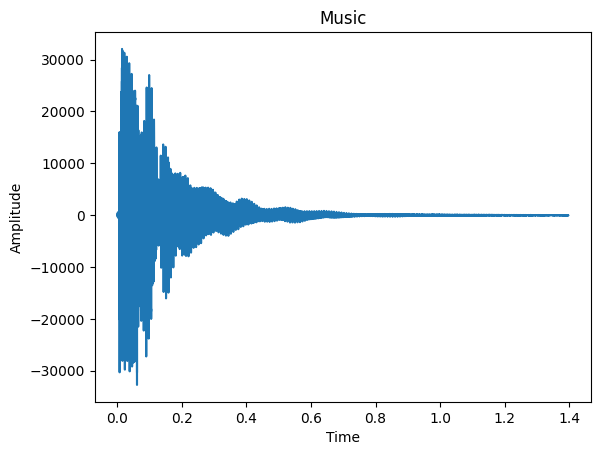

In [227]:
plt.plot(time, canal1)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Music')
plt.show()

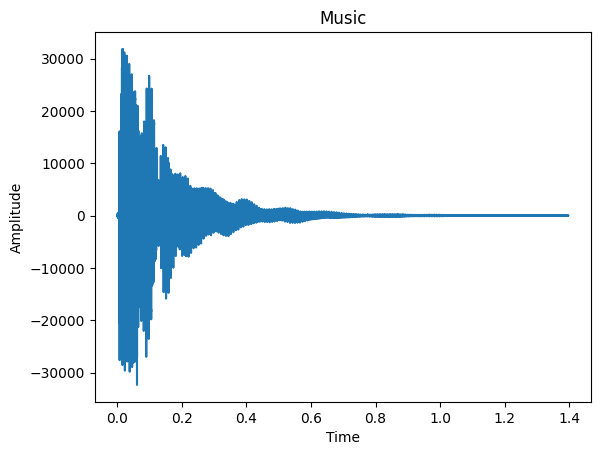

In [228]:
plt.plot(time, canal2)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Music')
plt.show()

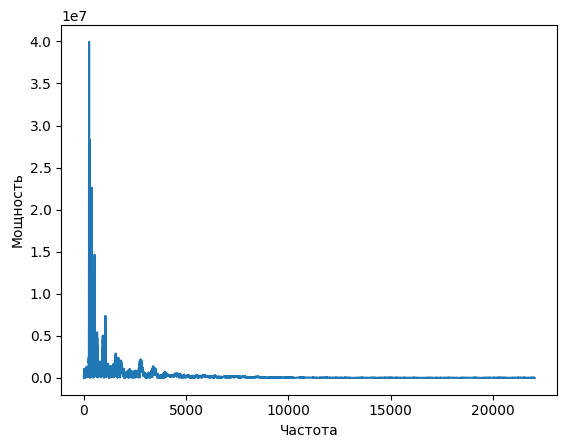

In [229]:
from scipy.fft import  rfft, rfftfreq, irfft


# число точек в normalized_tone
N = int(samplerate * duration)

yf = rfft(canal1)
xf = rfftfreq(N, 1 / samplerate)

plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

In [230]:
points_per_freq = len(xf) / (max(xf))

# Наши целевые частоты 
target_idx_hf = int(points_per_freq * 800)
target_idx_lf = int(points_per_freq * 400)

yf_hf = yf.copy()
yf_lf = yf.copy()
yf_bp = yf.copy()
yf_bp_rvs = yf.copy()

yf_hf[:target_idx_hf] = 0

yf_lf[target_idx_lf:] = 0

yf_bp[:target_idx_lf] = 0
yf_bp[target_idx_hf:] = 0

yf_bp_rvs = yf_bp_rvs - yf_bp.copy()

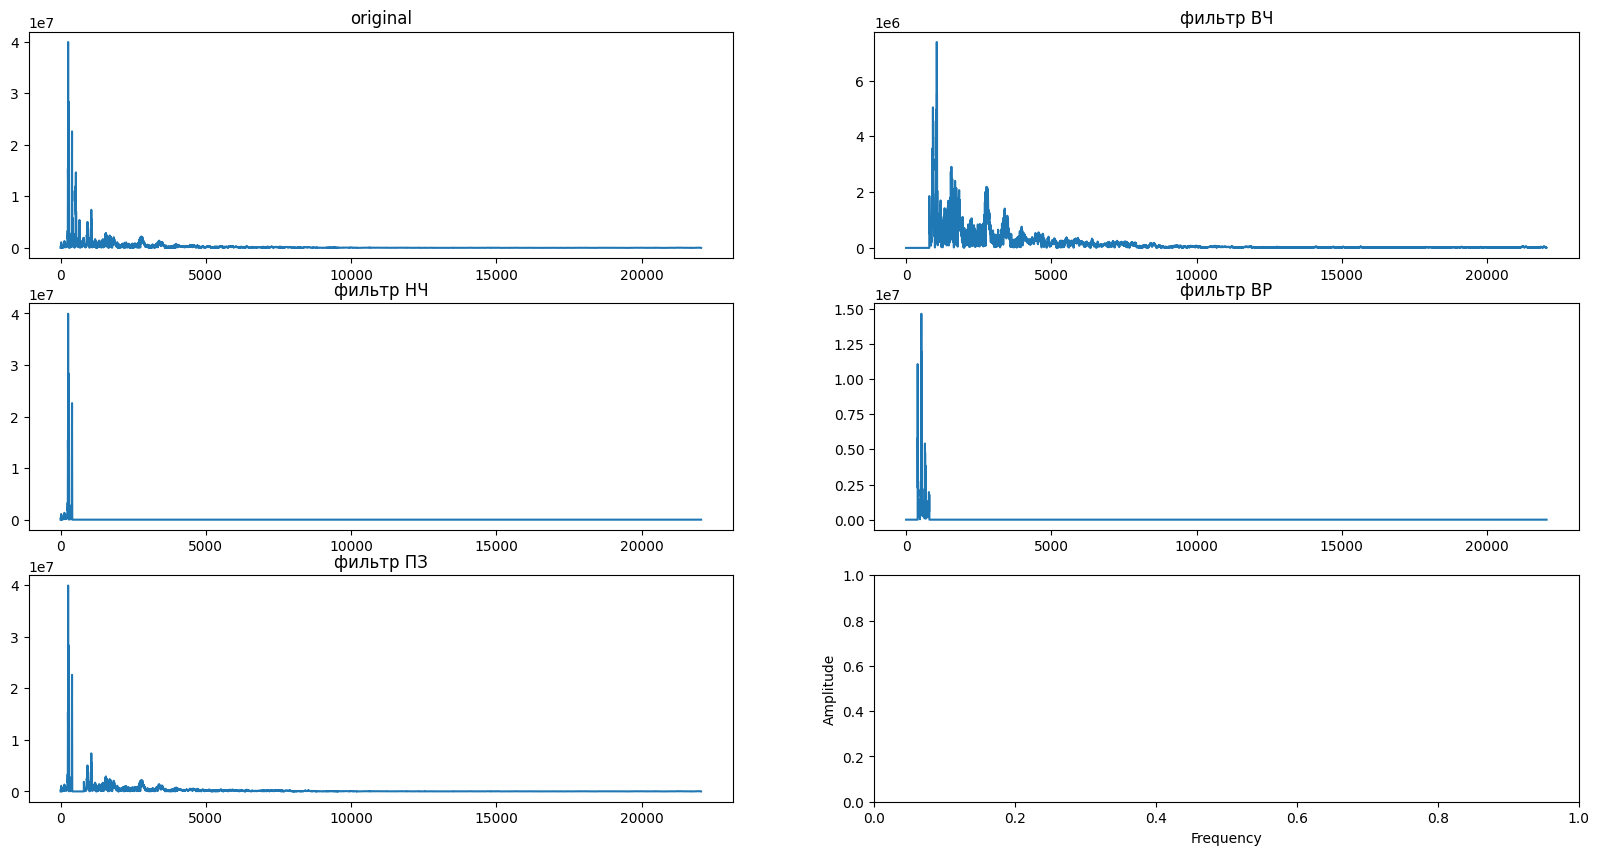

In [231]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(20, 10))

ax[0,0].plot(xf, np.abs(yf))
ax[0,0].set_title("original")

ax[0,1].plot(xf, np.abs(yf_hf))
ax[0,1].set_title("фильтр ВЧ")

ax[1,0].plot(xf, np.abs(yf_lf))
ax[1,0].set_title("фильтр НЧ")

ax[1,1].plot(xf, np.abs(yf_bp))
ax[1,1].set_title("фильтр BP")

ax[2,0].plot(xf, np.abs(yf_bp_rvs))
ax[2,0].set_title("фильтр ПЗ")


plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.show()

In [232]:
new_sig_hf = irfft(yf_hf)
new_sig_lf = irfft(yf_lf)
new_sig_bp = irfft(yf_bp)
new_bp_rvs = irfft(yf_bp_rvs)

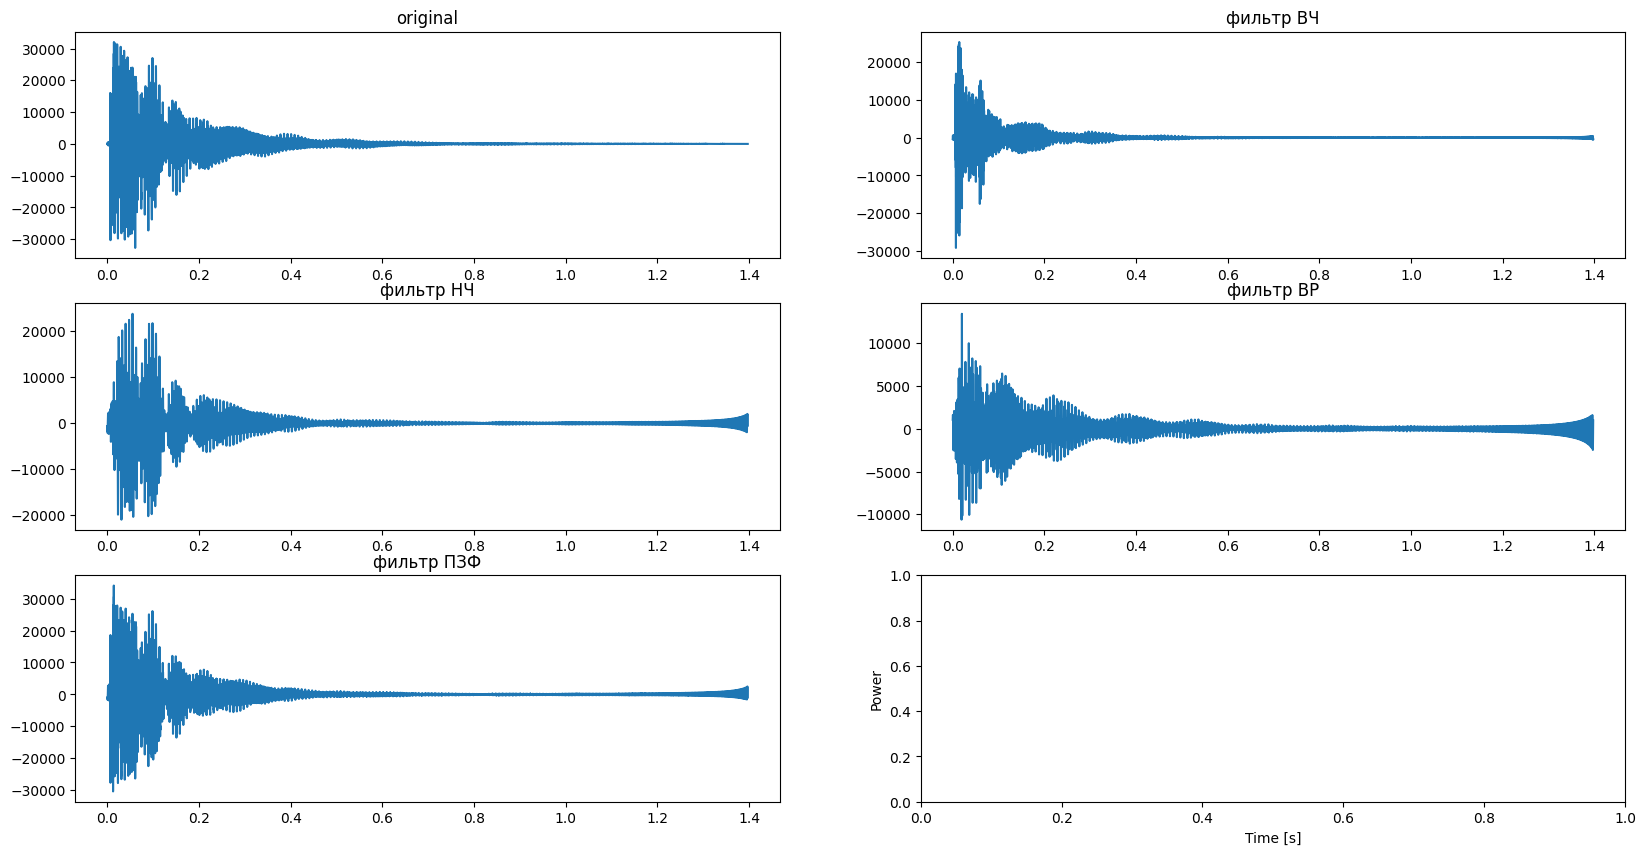

In [233]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(20, 10))


ax[0,0].plot(time, canal1)
ax[0,0].set_title("original")

ax[0,1].plot(time[:-1], new_sig_hf)
ax[0,1].set_title("фильтр ВЧ")

ax[1,0].plot(time[:-1], new_sig_lf)
ax[1,0].set_title("фильтр НЧ")

ax[1,1].plot(time[:-1], new_sig_bp)
ax[1,1].set_title("фильтр BP")

ax[2,0].plot(time[:-1], new_bp_rvs)
ax[2,0].set_title("фильтр ПЗФ")

plt.xlabel('Time [s]')
plt.ylabel('Power')

plt.show()

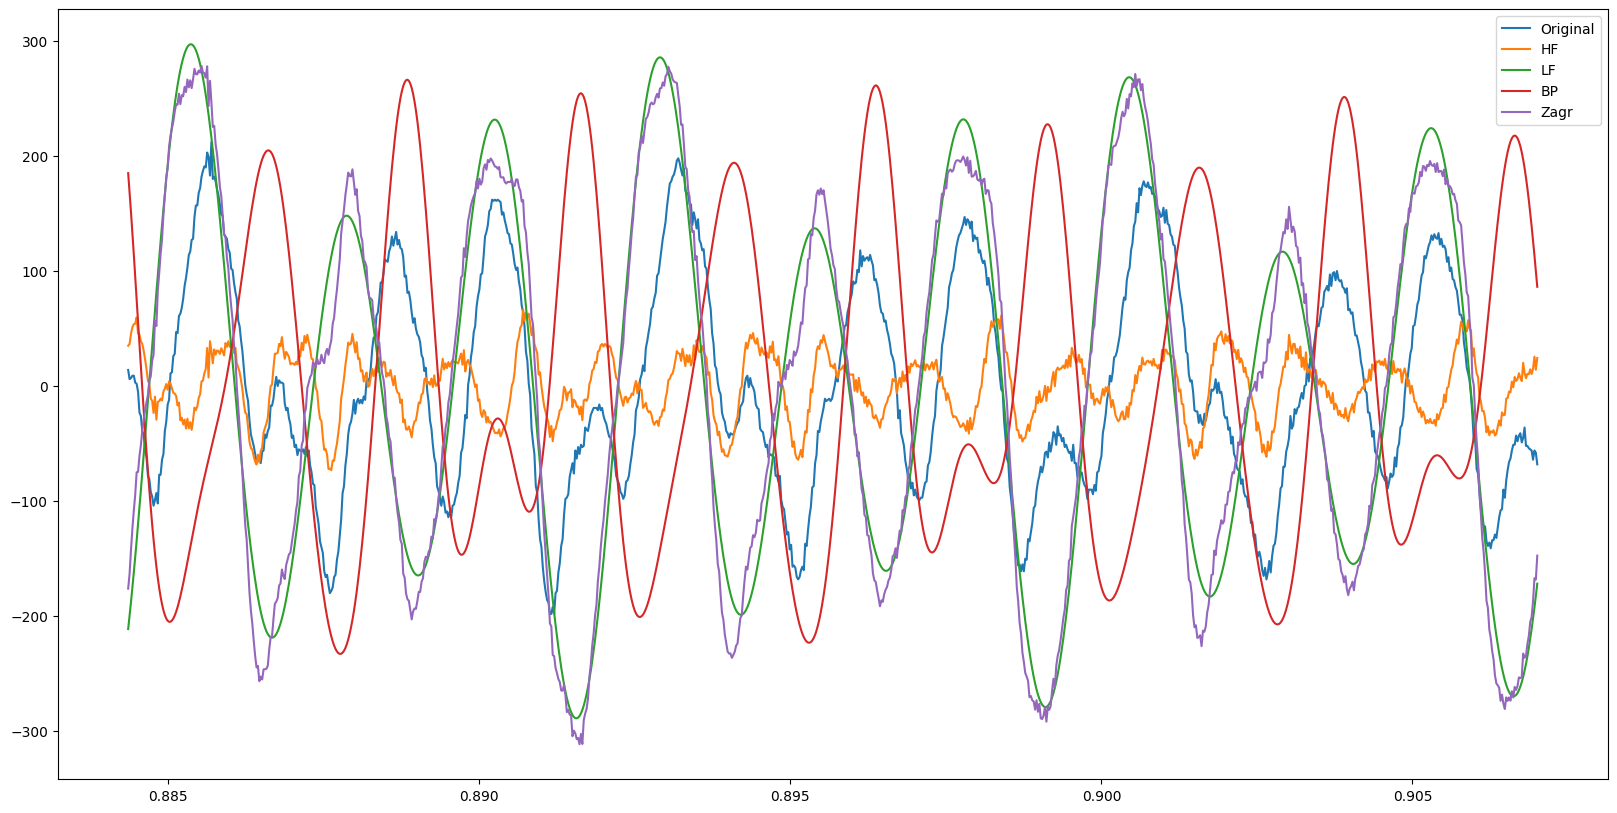

In [234]:
fig, ax = plt.subplots( figsize=(20, 10) )


original, = ax.plot(time[39000:40000], canal1[39000:40000], label='Original')
signal_hf, = ax.plot(time[39000:40000], new_sig_hf[39000:40000], label='HF')
signal_lf, = ax.plot(time[39000:40000], new_sig_lf[39000:40000], label='LF')
signal_bp, = ax.plot(time[39000:40000], new_sig_bp[39000:40000], label='BP')
signal_bp_rvs, = ax.plot(time[39000:40000], new_bp_rvs[39000:40000], label='Zagr')


ax.legend(handles=[original, signal_hf, signal_lf, signal_bp, signal_bp_rvs])

plt.show()

In [235]:
sd.play(canal1, samplerate)

In [236]:
sd.play(new_sig_hf, samplerate) # this one hurt my ears like bloody hell was coming DO NOT PLAY IT (or turn down the volume at least)

In [237]:
sd.play(new_sig_lf, samplerate, blocking = False) # the same about this one

In [238]:
sd.play(new_sig_bp, samplerate) # the same about this one

In [239]:
sd.play(new_bp_rvs, samplerate) # the same about this one

In [240]:
sd.stop()

In [241]:
def exponential_smoothing(values, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [values[0], values[1]]  # first value is same as series
    
    for n in range(1, len(values)):
        result.append(alpha * result[n] + (1 - alpha) * values[n-1])
    
    return result

In [242]:
def plot_exponential_smoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context("seaborn-v0_8-white"):
        

        plt.figure(figsize=(15, 7))

        plt.plot(series[1], "c", label="Actual")

        for alpha in alphas:
            plt.plot(
                exponential_smoothing(series[1], alpha), label="Alpha {}".format(alpha)
            )

      
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True)

In [243]:
def double_exponential_smoothing(values, alpha, beta):
    result = [values[0]]
    for n in range(1, len(values)+1):
        if n == 1:
            level, trend = values[0], values[1] - values[0]
        if n >= len(values): # прогнозируем
            value = values[len(values)-1]
        else:
            value = values[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [244]:
def plot_double_exponential_smoothing(signal_part, alphas, betas):
    with plt.style.context('seaborn-v0_8-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(signal_part[1], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        print(0)
        plt.plot(signal_part[1], label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

In [245]:
signal_part = canal1[39000:40000]
time_part = time[39000:40000]
 
ts = pd.Series([time[39000:40000],canal1[39000:40000]])  

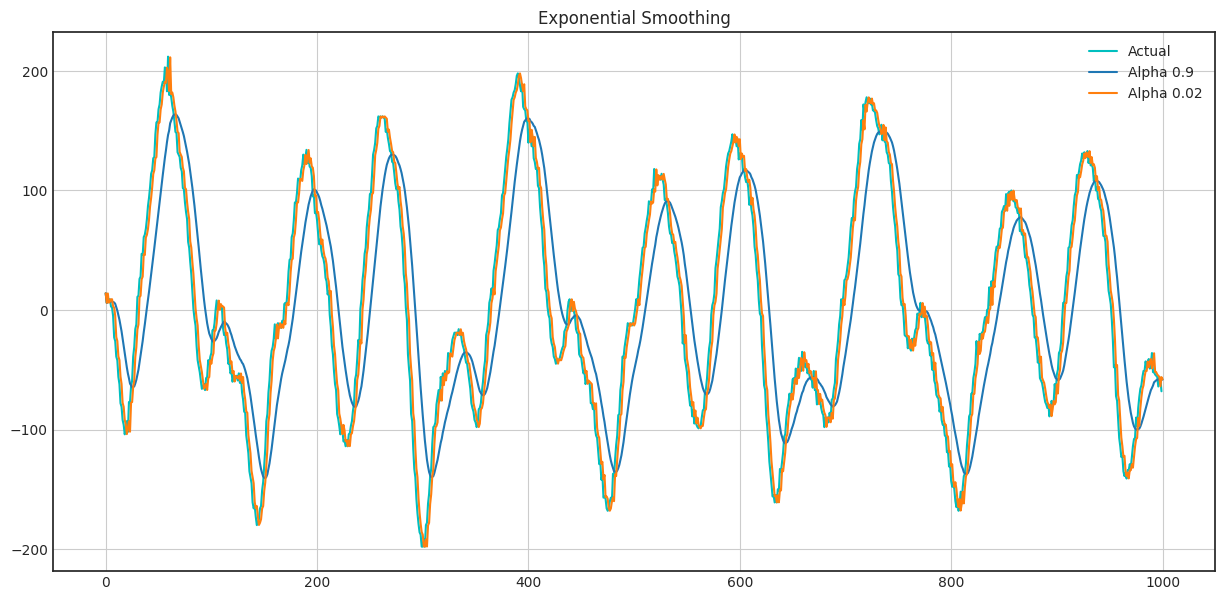

In [246]:
plot_exponential_smoothing(ts, [0.9, 0.02])

0


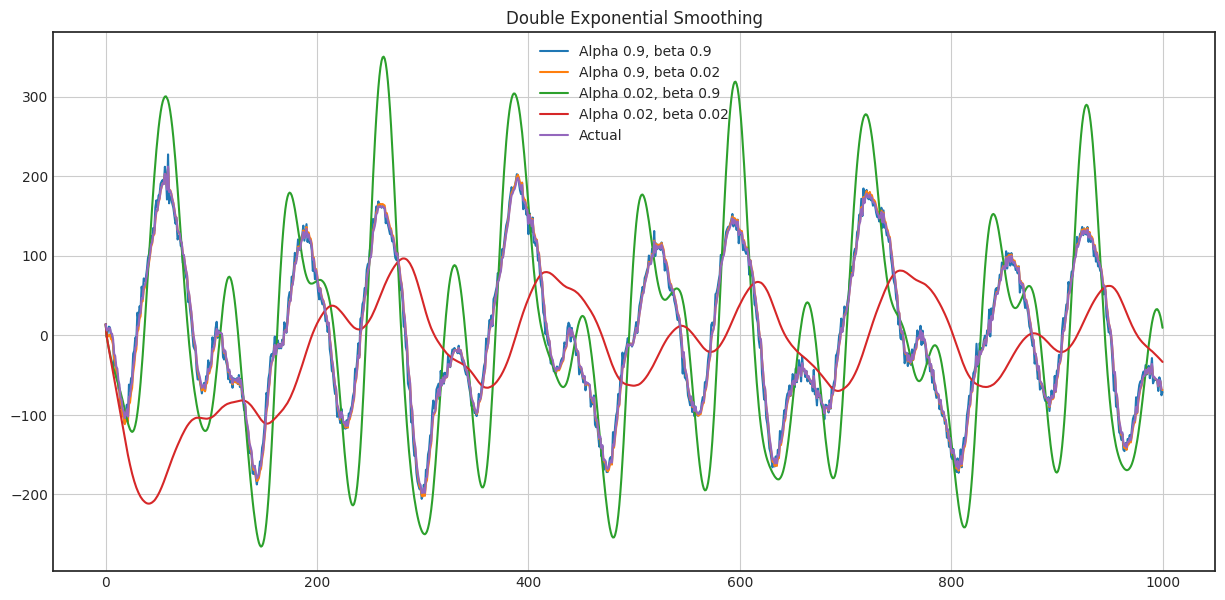

In [247]:
plot_double_exponential_smoothing(ts, [0.9, 0.02], [0.9, 0.02])

In [248]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

In [249]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

In [250]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

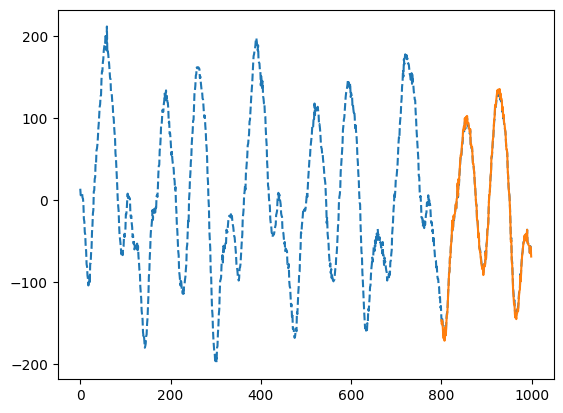

In [251]:
count = 200
ind = len(signal_part) - count
vals = triple_exponential_smoothing(signal_part, 12, 0.716, 0.029, 0.993, count)
# вырезаем отрезок по x, чтобы посмотреть
x = range(ind + count)
x_pr = range(ind, ind + count)
# отрисовываем. Сплошная линия - предсказание.
plt.plot(x[:], signal_part[:], linestyle='dashed')
plt.plot(x_pr, vals[ind:ind+count])

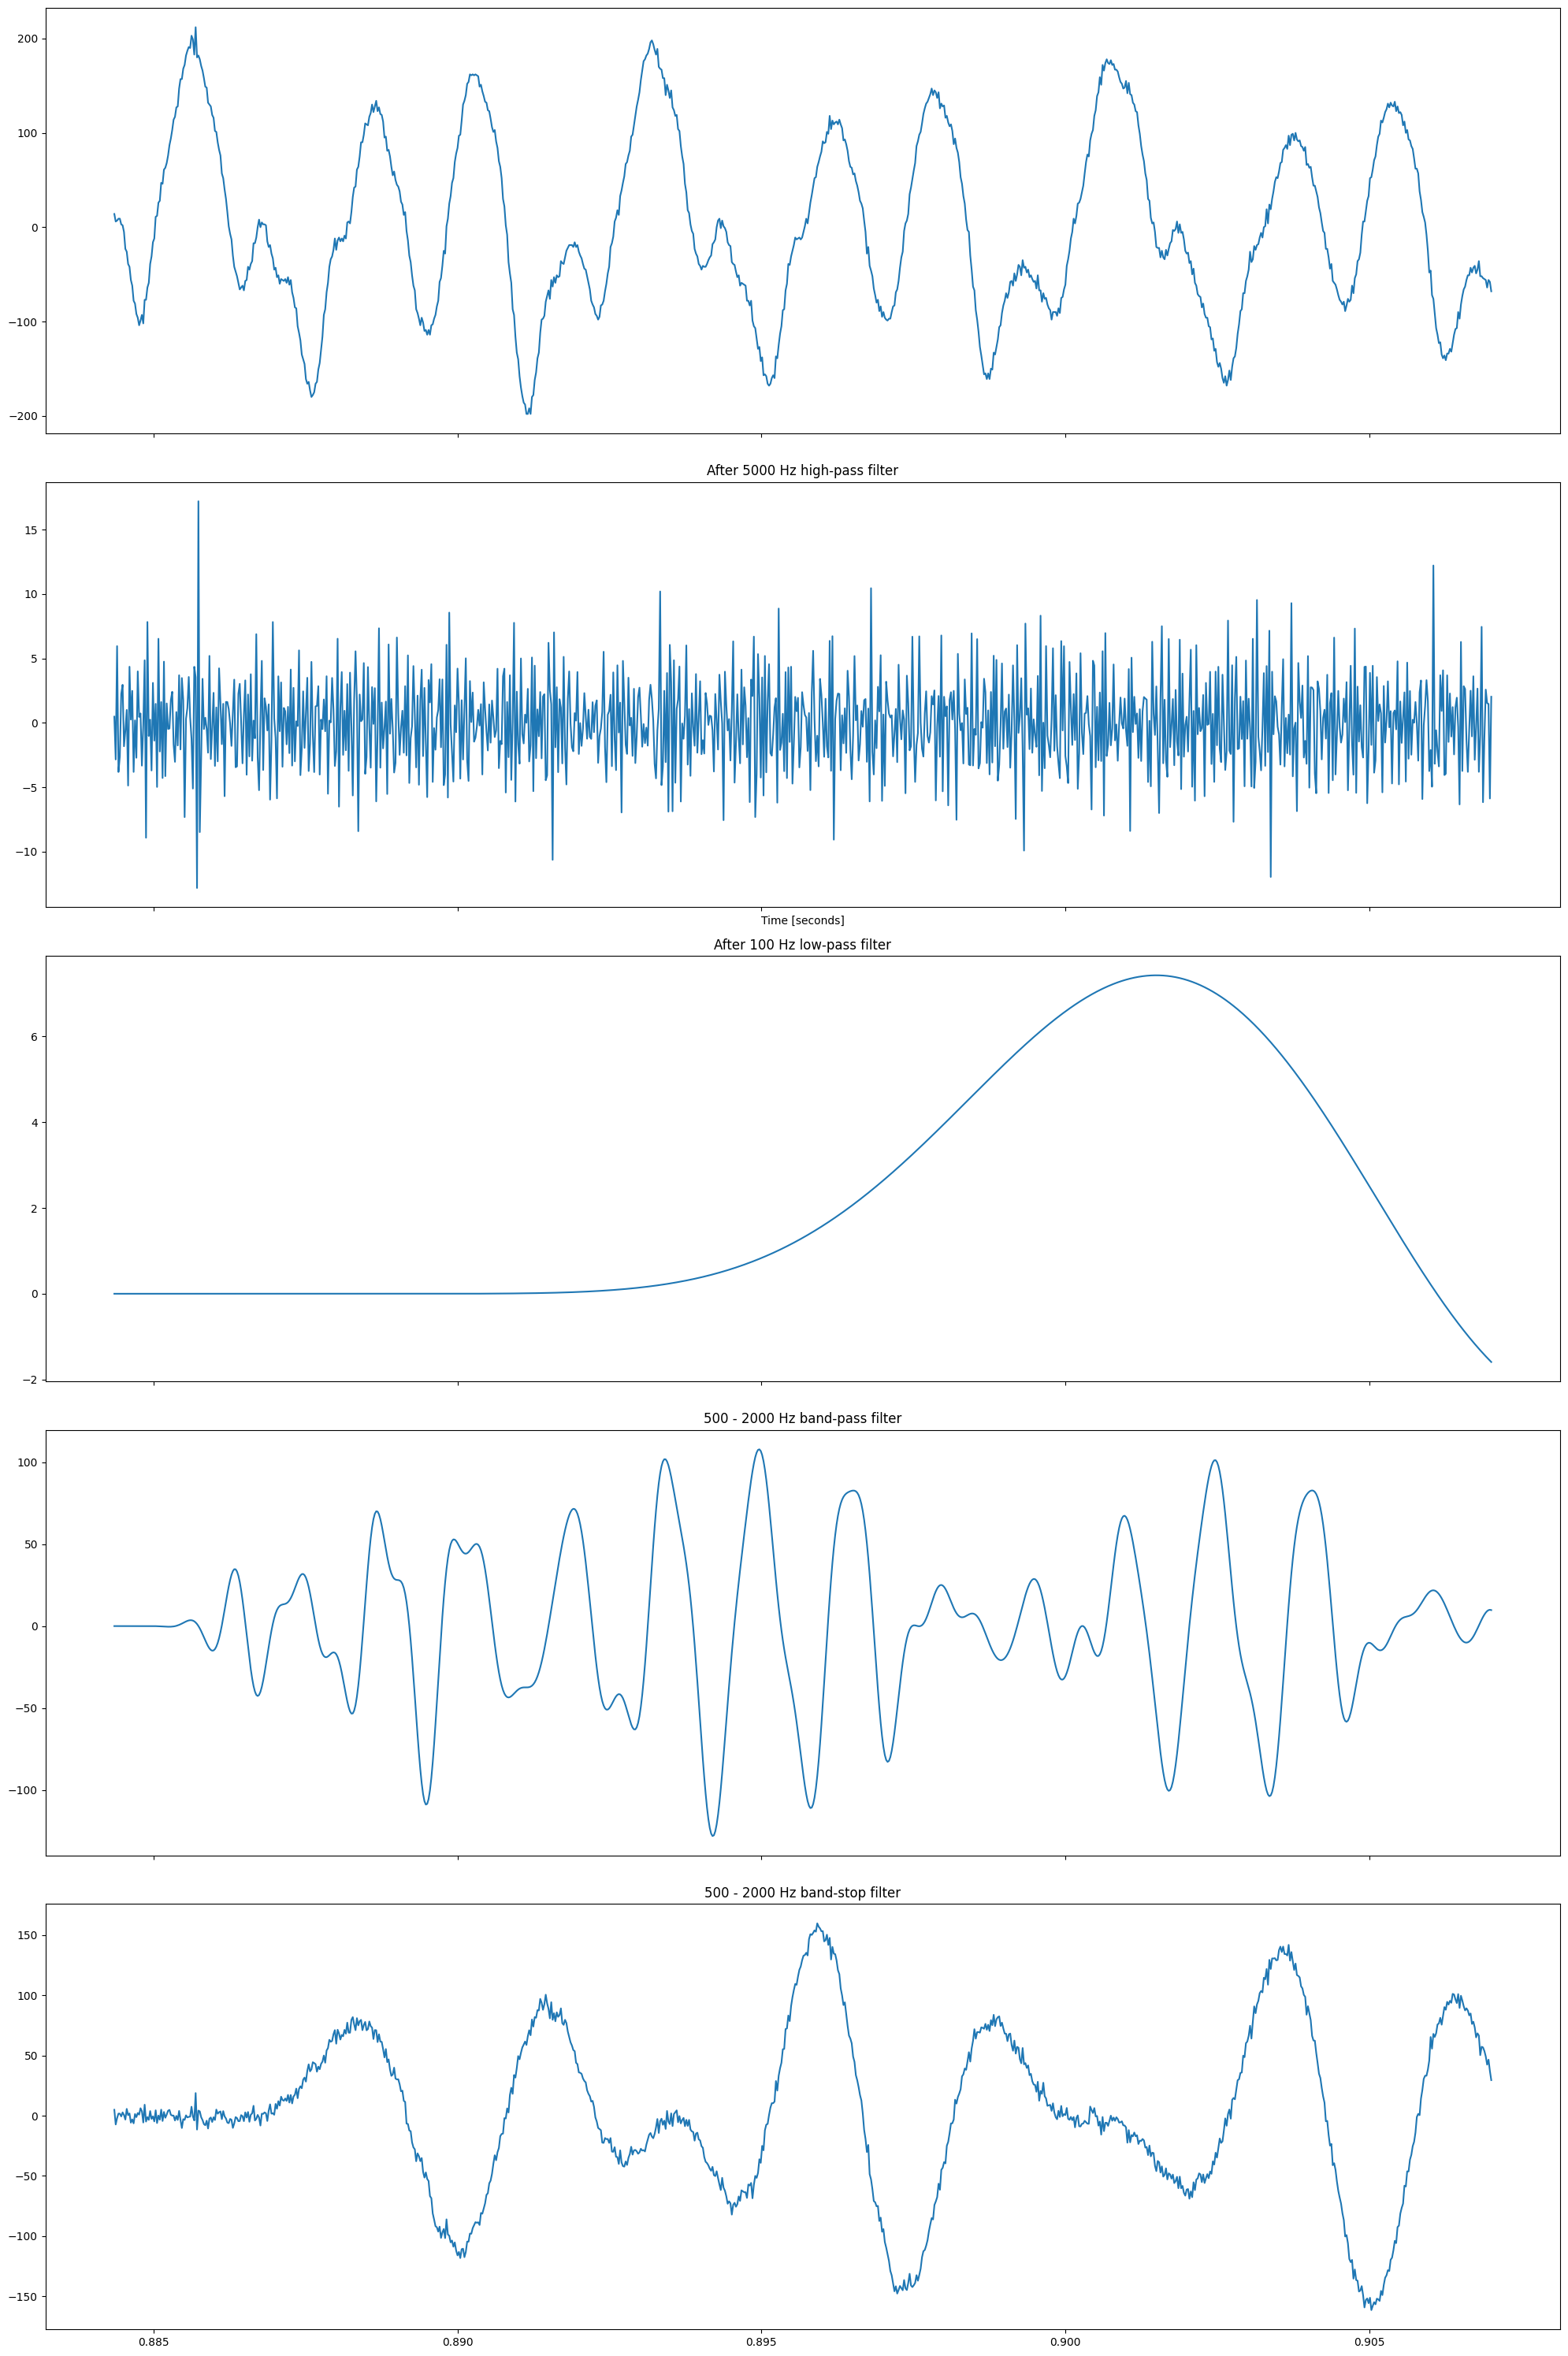

In [252]:
# high pass
sos_hp = signal.cheby1(10, 1, 5000, 'hp', fs=samplerate, output='sos')
filtered_hp = signal.sosfilt(sos_hp, signal_part)


# low pass
sos_lp = signal.cheby1(10, 1, 100, 'lp', fs=samplerate, output='sos')
filtered_lp = signal.sosfilt(sos_lp, signal_part)


# band pass
sos_bp = signal.cheby1(10, 1, [500, 2000], 'bp', fs=samplerate, output='sos')
filtered_bp = signal.sosfilt(sos_bp, signal_part)

# band pass
sos_bs = signal.cheby1(10, 1, [500, 2000], 'bs', fs=samplerate, output='sos')
filtered_bs = signal.sosfilt(sos_bs, signal_part)


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(20,30))
ax1.plot(time_part, signal_part)

ax2.plot(time_part, filtered_hp)
ax2.set_title('After 5000 Hz high-pass filter')

ax3.plot(time_part, filtered_lp)
ax3.set_title('After 100 Hz low-pass filter')

ax4.plot(time_part, filtered_bp)
ax4.set_title('500 - 2000 Hz band-pass filter')
 
ax5.plot(time_part, filtered_bs)
ax5.set_title('500 - 2000 Hz band-stop filter')

ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

In [253]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

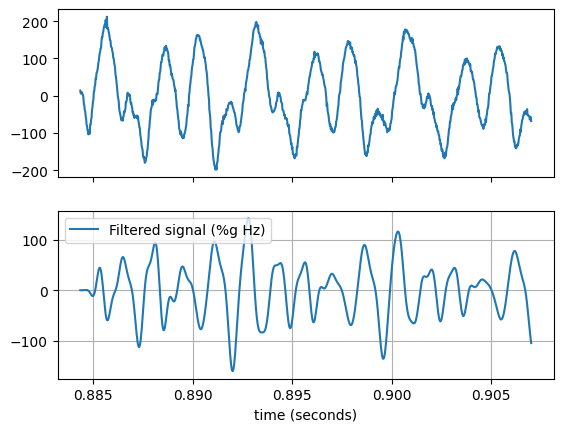

In [254]:
from scipy.signal import butter, lfilter

# Sample rate and desired cutoff frequencies (in Hz).
fs = samplerate

lowcut = 500.0
highcut = 2000.0


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(time_part, signal_part, label='Noisy signal')

y = butter_bandpass_filter(signal_part, lowcut, highcut, fs, order=6)
ax2.plot(time_part, y, label='Filtered signal (%g Hz)')

plt.xlabel('time (seconds)')
 
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()